# 1.5.10 Feature Matching + Homography to find Objects

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [11]:
MIN_MATCH_COUNT = 10
img1 = cv2.imread('im0.png',0) # queryImage
img2 = cv2.imread('im1.png',0) # trainImage

In [12]:
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

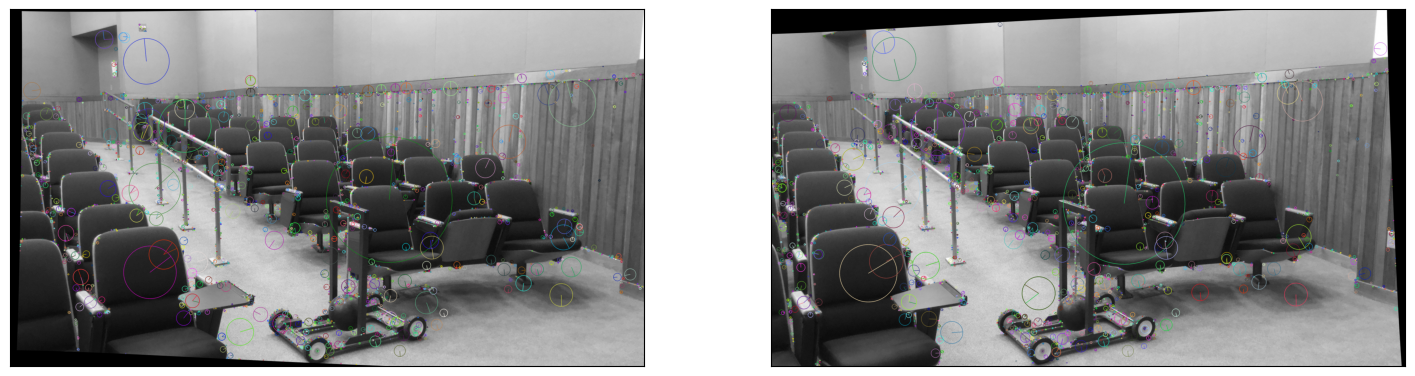

In [13]:
img1v = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
img2v = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (18,18))
plt.subplot(1,2,1), plt.imshow(img1v), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(img2v), plt.xticks([]), plt.yticks([])
plt.show()

In [14]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [15]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.125*n.distance:
        good.append(m)

In [16]:
print(len(good))

14


In [17]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

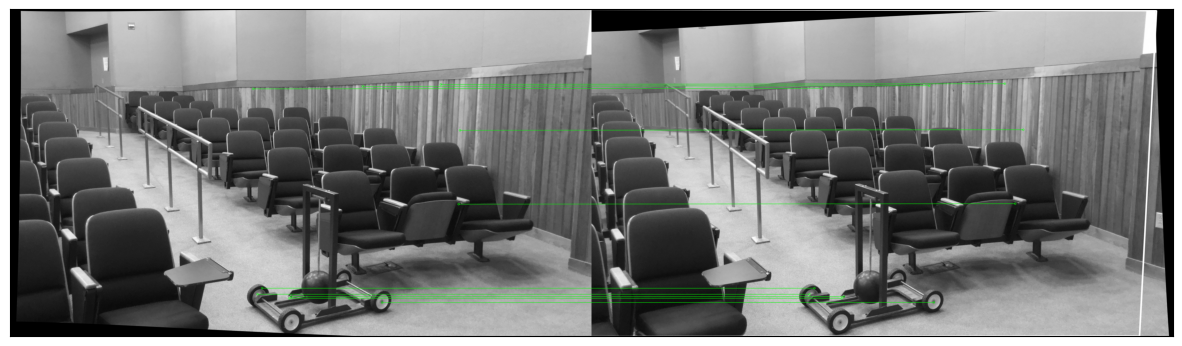

(<matplotlib.image.AxesImage at 0x14bc1101760>, ([], []), ([], []), None)

In [18]:
draw_params = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize = (15,15))
plt.imshow(img3, 'gray'), plt.xticks([]), plt.yticks([]), plt.show()